# CIFAR 10 v2

### Extract CIFAR-10 training data

Remove CIFAR-10 and train directories if they exist. Open the train.7z archive and extract its contents into the current directory. Rename the extracted train folder to CIFAR-10.

In [1]:
from pathlib import Path
import py7zr, shutil

shutil.rmtree("CIFAR-10", ignore_errors=True)
shutil.rmtree("train", ignore_errors=True)

archive = "train.7z"

with py7zr.SevenZipFile(archive, mode="r") as z:
    z.extractall(path=".")

Path("train").rename("CIFAR-10")

print(f"extracted {archive} to CIFAR-10/")

extracted train.7z to CIFAR-10/


### Calculate the mean and standard deviation

Load the training CSV file. Walk through each CIFAR-10 image by id. Open as RGB, convert to float in the 0 to 1 range, and accumulate per-channel sums and squared sums across all pixels. Compute the per-channel mean and standard deviation from those totals. Clip numerical noise, round to four decimals, cast to tuples, and print them.

The mean and std values are needed for normalization so inputs are centered and comparably scaled, which stabilizes optimization and speeds convergence.

In [2]:
import pandas as pd
from pathlib import Path
from PIL import Image
import numpy as np

df = pd.read_csv("trainLabels.csv")
root_path = Path("CIFAR-10")

sum_ = np.zeros(3, dtype=np.float64)
sum_sq = np.zeros(3, dtype=np.float64)
n = 0

for img_id in df["id"]:
    x = (
        np.asarray(
            Image.open(root_path / f"{img_id}.png").convert("RGB"), dtype=np.float32
        )
        / 255.0
    )

    sum_ += x.sum(axis=(0, 1))
    sum_sq += (x * x).sum(axis=(0, 1))
    n += x.shape[0] * x.shape[1]

mean = sum_ / n
var = (sum_sq / n) - mean * mean
std = np.sqrt(np.clip(var, 0, None))

data_mean = tuple(np.round(mean, 4).tolist())
data_std = tuple(np.round(std, 4).tolist())

print("data_mean:", data_mean)
print("data_std: ", data_std)

data_mean: (0.4914, 0.4822, 0.4465)
data_std:  (0.247, 0.2435, 0.2616)


### Split CIFAR-10 data into train and test sets

Read the CIFAR-10 labels. Create an 80/20 stratified split into training and testing so class balance is preserved. Write out two CSVs as train_split.csv and test_split.csv. Print the row counts and show a preview of both DataFrames to confirm the structures.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("trainLabels.csv")

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=17
)

train_df.to_csv("train_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

print("Training size:", len(train_df))
print("Testing size:", len(test_df))

print("\ntrain_df.head():")
print(train_df.head())
print("\ntest_df.head():")
print(test_df.head())

Training size: 40000
Testing size: 10000

train_df.head():
          id label
32881  32882   cat
43589  43590  bird
35875  35876   cat
37064  37065  ship
35849  35850  bird

test_df.head():
          id  label
10828  10829   frog
18264  18265   deer
14738  14739  horse
12811  12812    cat
16847  16848   ship


### Train model

Load the train and test CSVs and wire up a dataset that reads PNGs from CIFAR-10 by id. Convert to tensors, and normalize with the previously computed mean and std. For training only, apply augmentation with random crop, horizontal flip, and a small chance of random erasing to simulate occlusions. Build DataLoaders for train and test with shuffling on the train side.

Define a compact CNN with two 3x3 convolutional layers with batch normalization after each. Use a max pool after each to downsample to 8x8, and a global average pool to collapse features to 1x1 per channel before the 10 way linear classifier output. Use cross entropy with label smoothing to reduce overconfidence and Adam with a small weight decay for regularization.

Run a train/test loop for 60 epochs using a helper that switches the model in and out of training and testing modes. Zero gradients on each iteration. Perform the forward and backward passes, and track average loss and accuracy. After each epoch, print metrics for both splits and append them to history arrays. Drop the learning rate by half at epochs 30 and 45 to improve training.

In [4]:
import pandas as pd
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


CLASSES = {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9,
}


class ImageDataset(Dataset):
    def __init__(self, image_dir, csv_file, mean, std, train):
        self.image_dir = Path(image_dir)
        self.df = pd.read_csv(csv_file)

        if train:
            self.tf = transforms.Compose(
                [
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                    transforms.RandomErasing(p=0.1),
                ]
            )
        else:
            self.tf = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img = Image.open(self.image_dir / f"{row['id']}.png").convert("RGB")
        x = self.tf(img)
        y = CLASSES[row["label"]]
        return x, y


class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.gap = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


train_data = ImageDataset(
    "CIFAR-10",
    "train_split.csv",
    data_mean,
    data_std,
    True,
)

test_data = ImageDataset(
    "CIFAR-10",
    "test_split.csv",
    data_mean,
    data_std,
    False,
)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=0)

model = Network()

loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)


def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    total_loss, correct, count = 0.0, 0, 0

    for images, labels in loader:
        if train_mode:
            optimizer.zero_grad()

        logits = model(images)
        loss = loss_function(logits, labels)

        if train_mode:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct += (logits.argmax(1) == labels).sum().item()
        count += labels.size(0)

    return total_loss / count, correct / count


num_epochs = 60

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    training_loss, training_accuracy = run_epoch(train_loader, True)
    test_loss, test_accuracy = run_epoch(test_loader, False)

    print(
        f"epoch: {epoch:02d}  training_loss: {training_loss:.4f}  training_accuracy: {training_accuracy:.4f}. test_loss: {test_loss:.4f}  test_accuracy: {test_accuracy:.4f}"
    )

    train_losses.append(training_loss)
    train_accuracies.append(training_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if epoch in {30, 45}:
        for g in optimizer.param_groups:
            g["lr"] *= 0.5
        print(f"Learning rate updated: {optimizer.param_groups[0]['lr']:.2e}")

epoch: 01  training_loss: 1.9329  training_accuracy: 0.3420. test_loss: 1.8550  test_accuracy: 0.3700
epoch: 02  training_loss: 1.7712  training_accuracy: 0.4198. test_loss: 1.7970  test_accuracy: 0.3953
epoch: 03  training_loss: 1.7104  training_accuracy: 0.4495. test_loss: 1.8553  test_accuracy: 0.3695
epoch: 04  training_loss: 1.6739  training_accuracy: 0.4689. test_loss: 1.7433  test_accuracy: 0.4310
epoch: 05  training_loss: 1.6438  training_accuracy: 0.4843. test_loss: 1.6805  test_accuracy: 0.4625
epoch: 06  training_loss: 1.6189  training_accuracy: 0.4939. test_loss: 1.7838  test_accuracy: 0.4147
epoch: 07  training_loss: 1.6001  training_accuracy: 0.5050. test_loss: 1.6612  test_accuracy: 0.4584
epoch: 08  training_loss: 1.5804  training_accuracy: 0.5157. test_loss: 1.5975  test_accuracy: 0.5113
epoch: 09  training_loss: 1.5676  training_accuracy: 0.5225. test_loss: 1.5657  test_accuracy: 0.5227
epoch: 10  training_loss: 1.5556  training_accuracy: 0.5289. test_loss: 1.5484  te

#### Add graphs showing training progress

Create a range from 1 through the number of recorded epochs, to allow easy epoch count tuning. Draw figures for training and test loss and accuracy over the range. These plots create a visual of convergence, and the effects of experimenting with hyperparamter tuning.

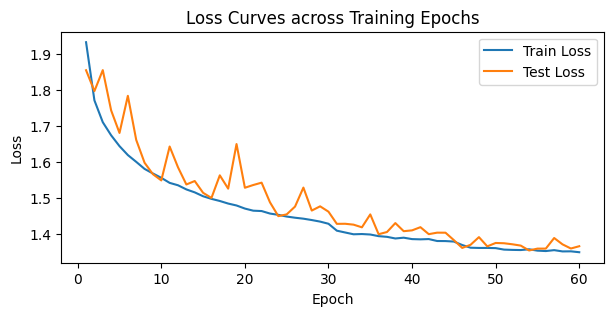

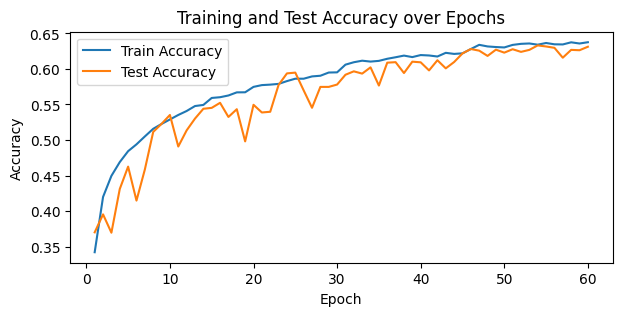

In [5]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(7, 3))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves across Training Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(7, 3))
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy over Epochs")
plt.legend()
plt.show()

#### Model Summary

Instantiate the network and switch it to eval mode so layers like dropout are disabled and batch norm uses running stats. Call `torchinfo.summary` with a dummy input size of 1×3×32×32 to generate a layer by layer report. Show columns for kernel size, output tensor shape, parameter counts, and whether those params are trainable. Limit the module expansion to depth 3 so the printout stays readable.

In [6]:
from torchinfo import summary

model = Network()
model.eval()

summary(
    model,
    input_size=(1, 3, 32, 32),
    col_names=("kernel_size", "output_size", "num_params", "trainable"),
    depth=3,
)

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #                   Trainable
Network                                  --                        [1, 10]                   --                        True
├─Conv2d: 1-1                            [3, 3]                    [1, 32, 32, 32]           896                       True
├─BatchNorm2d: 1-2                       --                        [1, 32, 32, 32]           64                        True
├─MaxPool2d: 1-3                         2                         [1, 32, 16, 16]           --                        --
├─Conv2d: 1-4                            [3, 3]                    [1, 64, 16, 16]           18,496                    True
├─BatchNorm2d: 1-5                       --                        [1, 64, 16, 16]           128                       True
├─MaxPool2d: 1-6                         2                         [1, 64, 8, 8]             --                        --
├─Adapt